In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn import over_sampling
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_recall_fscore_support, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from skopt import BayesSearchCV
from feature_engine.selection import SmartCorrelatedSelection

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

## Tratamento dos dados

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df = pd.read_csv("../data/air_system_previous_years.csv")

In [3]:
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,305200,283680,na,na,na,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,na,10476,1226,267998,521832,428776,4015854,895240,26330,118,0,532,734,4122704,51288,0,532572,0,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,1996924,99560,0,7336,7808,13776,13086,1010074,1873902,14726,6,0,0,1378576,447166,199512,154298,137280,138668,165908,229652,87082,4708,3646660,86,454,364,350,1393352,49028,688314,392208,341420,359780,366560,na,na,na,na,na,6700,33057.51,3646660,3646660,3582034,17733.0,260120,115626,6900,2942850,1209600,0,na,na,na,2291079.36,0,643536.96,0,0,0,0,38,98644,1179502,1286736,336388,36294,5192,56,na,0,3646660,na,6160,796,164860,350066,272956,1837600,301242,9148,22,0,na,na,na,na,na,na,na,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,239798,1450312,0,1620,1156,1228,34250,1811606,710672,34,0,0,0,790690,672026,332340,254892,189596,135758,103552,81666,46,0,2673338,128,202,576,4,1234132,28804,160176,139730,137160,130640,na,na,na,na,na,na,28000,41040.08,2673338,2673338,2678534,15439.0,7466,22436,248240,2560566,1209600,63328,0,124,0,2322692.16,0,236099.52,0,0,0,0,0,33276,1215280,1102798,196502,10260,2422,28,0,6,2673338,na,3584,500,56362,149726,100326,1744838,488302,16682,246,0,230,292,2180528,29188,22,20346,0,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,2038,5596,0,64,6,6,914,76,2478,2398,1692,0,0,6176,340,304,102,74,406,216,16,0,0,21614,2,12,0,0,2668,184,7632,3090,na,na,na,na,na,na,na,na,10580,12.69,21614,21614,21772,32,50,1994,21400,7710,120960

In [4]:
df.shape

(60000, 171)

In [5]:
for i in df.columns:
    df[i] = df[i].replace('na', np.nan)

In [6]:
## Retirando colunas que possuem mais de 10% de valores nulos

missing_proportion = df.isnull().mean().sort_values()
cols_to_drop = missing_proportion[missing_proportion > 0.10].index
df = df.drop(columns=cols_to_drop)
df.shape

(60000, 143)

In [7]:
## Valores únicos das variáveis do dataset

unique_values = []

for col in df.columns:
    valores_unicos = len(df[col].astype(str).value_counts())
    unique_values.append(valores_unicos)

unique_values.sort()
print(unique_values)

[2, 2, 22, 29, 48, 50, 54, 57, 69, 73, 135, 155, 160, 182, 222, 257, 334, 337, 403, 419, 448, 467, 618, 774, 895, 920, 987, 1033, 1056, 1099, 1272, 1314, 1531, 1768, 1894, 2062, 2216, 2316, 2423, 2808, 3056, 3344, 3512, 3566, 3861, 3877, 3919, 4056, 5356, 5420, 5619, 6312, 6564, 6683, 6798, 7379, 7618, 7880, 8111, 9018, 9065, 9185, 9298, 9725, 10118, 10583, 11569, 11817, 12307, 12835, 14736, 14790, 15911, 16548, 17301, 18933, 19697, 20515, 21099, 21531, 21997, 22076, 22095, 22628, 23072, 24214, 25167, 25241, 26313, 27832, 28278, 28319, 28496, 29282, 29594, 30140, 30171, 30470, 30674, 31712, 31796, 32126, 32427, 32915, 34078, 34111, 34489, 34559, 34629, 34922, 35189, 35194, 35959, 36289, 37823, 38246, 38360, 38555, 38652, 40165, 40616, 40798, 40917, 41816, 42087, 42099, 42559, 43569, 43572, 43860, 44602, 44673, 44841, 45044, 45481, 45965, 47724, 48205, 49347, 49348, 49350, 49393, 52849]


In [8]:
## Supondo que variáveis com menos de 10 valores distintos são categóricas

categorical_columns = []

for i in df.columns:
    if len(df[i].unique()) < 10:
        categorical_columns.append(i)
        print(f"Variavel categorica {i}")

Variavel categorica class
Variavel categorica cd_000


<Axes: title={'center': 'Proporção de negativos e positivos'}, xlabel='class'>

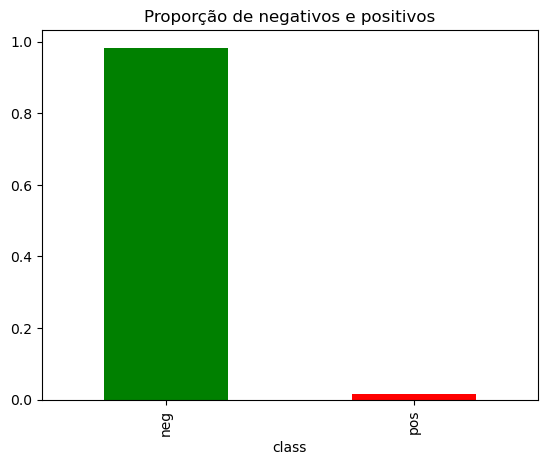

In [9]:
df["class"].value_counts(normalize=True).plot(kind="bar", title="Proporção de negativos e positivos", color=["green","red"])
# Variável alvo desbalanceada

In [10]:
df["class"].value_counts() # Valores absolutos

class
neg    59000
pos     1000
Name: count, dtype: int64

In [11]:
df["cd_000"].value_counts() # Variável possivelmente categórica com apenas uma classe. Passível de exclusão

cd_000
1209600    59324
Name: count, dtype: int64

In [12]:
# Variáveis categóricas possivelmente inexistentes

# df = df.drop(columns="cd_000")
# categorical_columns.remove("cd_000") 

### EXEMPLO DE VARIAVEL QUE VAI SER ELIMIADA PELO VARIANCETHRESHOLD

df.shape

(60000, 143)

In [13]:
## Rotulando o resto das variáveis como numéricas

numerical_cols = [col for col in df.columns if col not in categorical_columns]

In [14]:
categorical_columns

['class', 'cd_000']

In [15]:
## Transformando as variáveis numericas para float
# As variáveis categóricas ja estão no tipo esperado

for var in numerical_cols:
    df[var] = df[var].astype(float)

In [16]:
df.describe()

,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,ce_000,ci_000,cj_000,ck_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,cp_000,cq_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,5.666500e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.935500e+04,5.937100e+04,5.937100e+04,5.560000e+04,5.935800e+04,5.937100e+04,5.935800e+04,5.941100e+04,5.935800e+04,5.941100e+04,57277.000000,5.937100e+04,5.937100e+04,5.937100e+04,57500.000000,57499.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,59329.000000,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.935500e+04,57275.000000,57273.000000,57497.000000,57500.000000,5.935800e+04,5.935800e+04,5.941100e+04,5.941100e+04,5.927400e+04,5.983300e+04,5.930900e+04,5.930900e+04,5.674300e+04,5.952700e+04,5.727700e+04,55644.000000,5.927400e+04,5.674500e+04,5.749800e+04,5.966200e+04,5.966200e+04,5.966200e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,57276.000000,5.930900e+04,59331.000000,59331.000000,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,57497.000000,57276.000000,5.599200e+04,5.599200e+04,5.599200e+04,5.599400e+04,55993.000000,5.599300e+04,5.599200e+04,5.599100e+04,5.930900e+04,5.727600e+04,57274.000000,5.727400e+04,5.727400e+04,5.727300e+04,57273.000000,5.727400e+04,5.727400e+04,5.727700e+04,5.727600e+04,57277.000000,57277.000000,5.599300e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,5.933650e+04,3.560143e+08,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,4.370966e+05,1.108374e+06,1.657818e+06,4.993098e+05,3.556989e+04,5.114753e+03,1.809931e+06,9.016965e+03,1.143675e+03,9.794900e+02,5.913048e+04,9.328133e+04,3.461037e+06,3.002440e+06,1.004160e+06,4.424045e+05,0.496918,1.267365e+02,5.072046e+03,2.305804e+02,1117.825913,374.327380,1.221165e+04,1.019012e+04,1.097500e+04,7.225784e+03,1.056600e+04,1.119791e+05,1.078551e+06,1.546032e+06,1.051123e+06,1.162622e+03,7.849608e+03,4.420992e+03,8.066082e+03,8.724082e+04,1.476897e+06,2.135584e+06,1.018943e+05,1.737782e+04,6.617861e+02,42.073455,1.399652e+06,8.941175e+05,4.130969e+05,2.740070e+05,2.048756e+05,1.889412e+05,2.106288e+05,1.857874e+05,3.588284e+04,3.576672e+04,4.526177e+06,569.526565,921.775461,1372.646086,74.878261,1.809431e+06,5.794308e+04,4.922076e+05,5.100892e+05,8.036055e+04,5.941650e+04,4.515325e+06,4.515325e+06,4.112218e+06,2.202893e+04,1.019608e+05,39168.817123,4.056381e+05,3.803444e+06,6.434356e+04,3.481204e+06,1.028419e+05,7.143427e+05,2.336674e+03,2.195149e+04,1.610509e+05,5.314780e+05,1.282835e+06,1.341059e+06,4.105641e+05,6.442513e+04,1.922679e+04

## Preprocessamento para treinar o modelo

In [17]:
X = df.drop(columns="class", axis=1) # Variáveis independentes
y = df["class"] # Variável dependente

In [18]:
def label_transform(y):
    return y.replace({'neg': 0, 'pos': 1})

In [19]:
y_trans = label_transform(y)

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_cols),
    ]
)

In [25]:
# Testando varios modelos para escolher aquele que teve o melhor recall

models = {
    'Logistic Regression': LogisticRegression(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=321),
    # 'SVM': SVC(probability=True, random_state=321),
    # 'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=321),
    'AdaBoost': AdaBoostClassifier(random_state=321),
    'XGBoost': XGBClassifier(random_state=321),
    'LightGBM': LGBMClassifier(random_state=321),
    'CatBoost': CatBoostClassifier(random_state=321, verbose=0)
}

In [26]:
def run_models_pipeline(preprocessor, bal, scaler, threshold, sel_algorithm, dim_reduc, model, X, y):
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('balancer', bal),
        ('scaler', scaler),
        ('threshold', threshold),
        ('feature_selection', sel_algorithm),
        ('dim_reduction_algorithm', dim_reduc),
        ('classifier', model)
    ])

    cross_validation = KFold(n_splits=5, shuffle=True, random_state=123)
    scores = cross_val_score(pipeline, X, y, cv=cross_validation, scoring='f1')

    return [scores.mean(), pipeline]

In [27]:
# Compara f1_score usando validação cruzada para alguns modelos de classificação

all_scores = {}

for name, model in models.items():
    score_and_pipeline = run_models_pipeline(preprocessor, over_sampling.SMOTE(random_state=42),
                               StandardScaler(with_mean=False), VarianceThreshold(0.01),
                               SmartCorrelatedSelection(threshold=0.8, selection_method='variance'),
                               PCA(n_components=38), model, X, y_trans)

    all_scores[name] = score_and_pipeline
    print(f"{name} Recall Médio: {score_and_pipeline[0]}")

Logistic Regression Recall Médio: 0.4810634909011619
Gradient Boosting Recall Médio: 0.4266642253677733
Random Forest Recall Médio: 0.6114101768341218
AdaBoost Recall Médio: 0.3680412689483469
XGBoost Recall Médio: 0.629249564953945
[LightGBM] [Info] Number of positive: 47197, number of negative: 47197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 94394, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 47202, number of negative: 47202
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 944

In [28]:
best_score = max(list(all_scores.items()), key=lambda x: x[1])
best_model = best_score[0]
print(f"Melhor modelo:", best_model)

Melhor modelo: XGBoost


In [29]:
pipe = best_score[1][1]
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['aa_000', 'ac_000', 'ae_000',
                                                   'af_000', 'ag_000', 'ag_001',
                                                   'ag_002', 'ag_003', 'ag_004',
                                                   'ag_005', 'ag_006', 'ag_007',
                                                   'ag_008', 'ag_009', 'ah_000',
                                                   'ai_000', 'aj_000', 'ak_000',
                                                   'al_000', 'am_0', 'an_000',
                                                   'ao_000', 'ap_000', 'aq_000',
                                                   'ar_000', 'as_000', 'at_000',
                                                   'au_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=321, ...))])

### BayesSearchCV AdaBoost

In [142]:
## BayesSearchCV para o modelo que obteve o melhor recall

param_space = {
    'classifier__n_estimators': Integer(10, 200),
    'classifier__learning_rate': Real(0.005, 1.0, prior='log-uniform')
}

cross_validation = KFold(n_splits=5, shuffle=True, random_state=123)

bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=32,
    cv=cross_validation,
    scoring='recall',
    n_jobs=-1,
    random_state=123
)

bayes_search.fit(X_train, y_train_trans)

print(f"Melhores hiperparâmetros: {bayes_search.best_params_}")
print("Melhor score:", bayes_search.best_score_)

/home/diogo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/diogo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/diogo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/diogo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warnin

Melhores hiperparâmetros: OrderedDict([('classifier__learning_rate', 0.005761264639821054), ('classifier__n_estimators', 198)])
Melhor score: 0.9637065059454304


### BayesSearchCV GradientBoost

In [43]:
param_space = {
    'classifier__n_estimators': (50, 300),
    'classifier__max_depth': (3, 10),
    'classifier__min_samples_split': (2, 10),
    'classifier__min_samples_leaf': (1, 5),
    'classifier__subsample': (0.5, 1.0),
    'classifier__max_features': (1, 10),
    'threshold__threshold': (0.0, 0.3),
    'feature_selection__threshold': (0.6, 0.9),
    'dim_reduction_algorithm__n_components': (7, 46)
}

cross_validation = KFold(n_splits=5, shuffle=True, random_state=123)

bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=96,
    cv=cross_validation,
    scoring='recall',
    n_jobs=-1,
    random_state=123
)

bayes_search.fit(X, y_trans)

print(f"Melhores hiperparâmetros: {bayes_search.best_params_}")
print("Melhor score:", bayes_search.best_score_)

Melhores hiperparâmetros: OrderedDict([('classifier__max_depth', 3), ('classifier__max_features', 2), ('classifier__min_samples_leaf', 5), ('classifier__min_samples_split', 2), ('classifier__n_estimators', 50), ('classifier__subsample', 1.0), ('dim_reduction_algorithm__n_components', 39), ('feature_selection__threshold', 0.8011859032983073), ('threshold__threshold', 0.0)])
Melhor score: 0.9530595804263227


In [44]:
## Feature Importance do melhor modelo (39 features no total por causa da dimensão reduzida):

best_pipeline = bayes_search.best_estimator_
best_classifier = best_pipeline.named_steps['classifier']
feature_importances = best_classifier.feature_importances_
sorted(feature_importances)

[3.636939956807921e-05,
 3.932226531178352e-05,
 0.00021995653635713359,
 0.0009159653591828926,
 0.0009414841114395624,
 0.0009733995717052631,
 0.0010533393499105453,
 0.0012956018330217204,
 0.0013206861927186214,
 0.001623445432835893,
 0.0017610053334570952,
 0.002297970283762487,
 0.002939531231877121,
 0.0035259907970646943,
 0.004194281558337868,
 0.004226974069250084,
 0.004401509332170982,
 0.011163954281730825,
 0.01118423685599239,
 0.011357674299116138,
 0.01993853912506562,
 0.020141737091203062,
 0.021232735181512356,
 0.02224085292270237,
 0.023888255021643257,
 0.02867857234526542,
 0.0314993895747587,
 0.032107774264925594,
 0.03363702284255324,
 0.0359118293775486,
 0.03824426324646107,
 0.03997823470278959,
 0.04557500952796276,
 0.046285220192907275,
 0.05219038443590691,
 0.05278834461079996,
 0.05778485416735611,
 0.07168481154406722,
 0.26071947172975946]

10 Falsos Negativos, 187 Verdadeiros Positivos, 11044 Verdadeiros Negativos e 760 Falsos Positivos

- Observação: Um Falso Negativo equivale a 50 Falsos Positivos de prejuízo para a empresa
- O modelo tentou diminuir ao máximo o número de Falsos Positivos
- Se aumentasse em 10 o número de Falsos Negativos, seria preciso ter no mínimo 260 Falsos Positivos

### Testando o melhor modelo nos dados de teste 

As seguintes células precisam ser automatizadas em funções...

In [100]:
df_present = pd.read_csv("air_system_present_year.csv")

In [71]:
df_present.shape

(16000, 171)

In [73]:
cols_to_drop

Index(['ed_000', 'cl_000', 'cm_000', 'ec_00', 'dc_000', 'db_000', 'da_000',
       'cz_000', 'cy_000', 'cu_000', 'cv_000', 'ct_000', 'cx_000', 'ad_000',
       'ch_000', 'cg_000', 'co_000', 'cf_000', 'bk_000', 'bl_000', 'bm_000',
       'bn_000', 'ab_000', 'cr_000', 'bo_000', 'bp_000', 'bq_000', 'br_000'],
      dtype='object')

In [47]:
for i in df_present.columns:
    df_present[i] = df_present[i].replace('na', np.nan)

In [48]:
df_present = df_present.drop(columns=cols_to_drop)
df_present.shape

(16000, 143)

In [49]:
for var in numerical_cols:
    df_present[var] = df_present[var].astype(float)

In [101]:
X_present = df_present.drop(columns="class", axis=1)
y_present = df_present["class"]

In [51]:
y_present_trans = label_transform(y_present)

In [130]:
X_present.iloc[0:2,:].to_json(orient='records')

'[{"aa_000":60,"ab_000":"0","ac_000":"20","ad_000":"12","ae_000":"0","af_000":"0","ag_000":"0","ag_001":"0","ag_002":"0","ag_003":"2682","ag_004":"4736","ag_005":"3862","ag_006":"1846","ag_007":"0","ag_008":"0","ag_009":"0","ah_000":"3976","ai_000":"0","aj_000":"0","ak_000":"0","al_000":"1520","am_0":"2374","an_000":"11516","ao_000":"9480","ap_000":"111258","aq_000":"470","ar_000":"0","as_000":"0","at_000":"0","au_000":"0","av_000":"58","ax_000":"26","ay_000":"0","ay_001":"0","ay_002":"0","ay_003":"0","ay_004":"0","ay_005":"0","ay_006":"0","ay_007":"0","ay_008":"13124","ay_009":"2","az_000":"1956","az_001":"434","az_002":"76","az_003":"174","az_004":"190","az_005":"6198","az_006":"1148","az_007":"2948","az_008":"2","az_009":"0","ba_000":"8762","ba_001":"2566","ba_002":"480","ba_003":"380","ba_004":"196","ba_005":"516","ba_006":"86","ba_007":"66","ba_008":"74","ba_009":"0","bb_000":"124340","bc_000":"4","bd_000":"6","be_000":"4","bf_000":"0","bg_000":"3976","bh_000":"318","bi_000":"1076

In [52]:
y_pres_pred = bayes_search.predict(X_present)

In [124]:
y_pres_pred

array([0, 0, 0, ..., 0, 0, 0])

In [53]:
precision, recall, f1_score, support = precision_recall_fscore_support(y_present_trans, y_pres_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Support:", support)

Precision: [0.99911438 0.27403482]
Recall: [0.938624   0.96533333]
F1 Score: [0.96792503 0.42688679]
Support: [15625   375]


In [54]:
best_pipeline = bayes_search.best_estimator_
best_classifier = best_pipeline.named_steps['classifier'].classes_

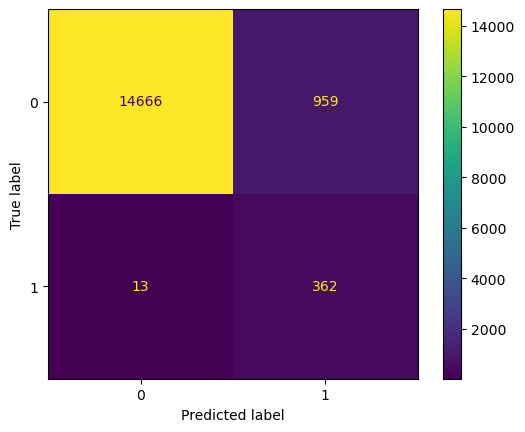

In [55]:
cm_present = confusion_matrix(y_present_trans, y_pres_pred, labels=best_classifier)
disp_present = ConfusionMatrixDisplay(confusion_matrix=cm_present, display_labels=best_classifier)
_ = disp_present.plot()

1466 Verdadeiros Negativos, 13 Falsos Negativos, 959 Falsos Positivos e 362 Verdadeiros Positivos

In [66]:
def calc_total_cost(confusion_matrix):
    return (confusion_matrix[1][0] * 500) + (confusion_matrix[1][1] * 10) + (confusion_matrix[1][1] * 10)

In [67]:
calc_total_cost(cm_present)

13740

Supondo que o gasto total da empresa com manutenção de sistemas de ar de caminhões do presente ano fosse parecido com o de 2020 (sem um modelo de Machine Learning), então a empresa economizaria aproximadamente um total de 23260 dólares em um ano!

In [232]:
## Tentando obter as variáveis em que o modelo julgou serem as mais importantes depois do PCA reduzir a dimensionalidade

pipeline_ = bayes_search.best_estimator_

X_preprocessed = pipeline_.named_steps['preprocessor'].transform(X_train)
X_over_sampled = pipeline_.named_steps['balancer'].fit_resample(X_preprocessed, y_train_trans)
X_scaled = pipeline_.named_steps['scaler'].transform(X_over_sampled)
X_var_thresholded = pipeline_.named_steps['var_threshold'].transform(X_scaled)
X_selected = pipeline_.named_steps['feature_selection'].transform(X_var_thresholded)
X_reducted = pipeline_.named_steps['dim_reduction_algorithm'].transform(X_selected)

X_inverted = pipeline_.named_steps['dim_reduction_algorithm'].inverse_transform(X_reduced)
X_inverted

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 94394) + inhomogeneous part.

### Exportando melhor modelo

In [56]:
joblib.dump(bayes_search, 'model.pk')

['model.pk']

In [57]:
joblib.dump(bayes_search, 'model.joblib')

['model.joblib']